In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/Users/priyadhage/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Import the dataset and give the column names
columns=['userId', 'productId','timestamp', 'ratings']
electronics_df=pd.read_csv('/Users/priyadhage/Desktop/Amazon-Customer_Reviews_1.csv',names=columns)

In [5]:
electronics_df.head(10)

,userId,productId,timestamp,ratings
0,ger yang,"B00QWO9P0O,B00LH3DMUO",2017-03-02T00:00:00.000Z,3
1,MG,"B00QWO9P0O,B00LH3DMUO",2016-08-31T00:00:00.000Z,4
2,Sharon Lambert,"B00QWO9P0O,B00LH3DMUO",2016-12-06T00:00:00.000Z,5
3,mark sexson,"B00QWO9P0O,B00LH3DMUO",2016-03-28T00:00:00.000Z,5
4,linda,"B00QWO9P0O,B00LH3DMUO",2017-04-22T00:00:00.000Z,5
5,Painter Marlow,"B00QWO9P0O,B00LH3DMUO",2016-02-17T00:00:00.000Z,5
6,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",2017-04-17T00:00:00.000Z,5
7,Lynn Pendegrass,"B00QWO9P0O,B00LH3DMUO",2017-04-16T00:00:00.000Z,5
8,K.R.,"B00QWO9P0O,B00LH3DMUO",2016-04-07T00:00:00.000Z,3
9,SilverLane,"B00QWO9P0O,B00LH3DMUO",2017-05-24T00:00:00.000Z,4


In [6]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [7]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 3 columns):
userId       28330 non-null object
productId    28332 non-null object
ratings      28332 non-null int64
dtypes: int64(1), object(2)
memory usage: 664.2+ KB


In [8]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  28332
Number of columns:  3


In [9]:
#Check the datatypes
electronics_df.dtypes

userId       object
productId    object
ratings       int64
dtype: object

In [10]:
# the dataset
electronics_df1=electronics_df.iloc[:28332,0:]

In [11]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 3 columns):
userId       28330 non-null object
productId    28332 non-null object
ratings      28332 non-null int64
dtypes: int64(1), object(2)
memory usage: 664.2+ KB


In [12]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    28332.000000
mean         4.514048
std          0.934957
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [13]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [14]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       2
productId    0
ratings      0
dtype: int64


In [16]:
electronics_df1['userId'].dropna(axis=0, how='any', inplace=False)

0              ger yang
1                    MG
2        Sharon Lambert
3           mark sexson
4                 linda
              ...      
28327    Mom2twinsplus1
28328         fireman21
28329    suzannalicious
28330            SandyJ
28331              Hung
Name: userId, Length: 28330, dtype: object

In [17]:
electronics_df1['ratings'].dropna(axis=0, how='any', inplace=False)

0        3
1        4
2        5
3        5
4        5
        ..
28327    5
28328    4
28329    5
28330    5
28331    4
Name: ratings, Length: 28332, dtype: int64

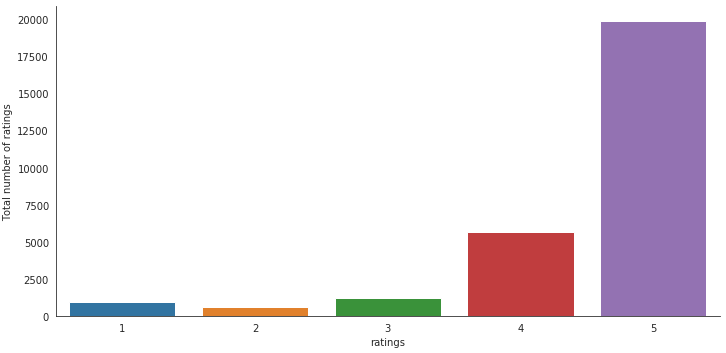

In [18]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [19]:
#Users and products
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  15852
Number of unique product in Raw data =  65


In [20]:
#3. Taking the subset of dataset to make it less sparse/ denser.
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
Amazon Customer    892
Mike                89
Dave                59
Chris               53
John                51
Kindle Customer     46
Alex                38
Bob                 35
Robert              35
David               34
dtype: int64


In [22]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 15 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 15 or more items = 2338
Number of unique users in the final data =  60
Number of unique products in the final data =  60


In [23]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.reset_index().pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,B01BH83OOM,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX
userId,,,,,,,,,,,,,,,,,,,,,
Adam,0.0,0.0,0.0,0.0,4.857143,5.000000,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Alex,0.0,5.0,0.0,0.0,4.400000,4.833333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0
Amanda,0.0,0.0,0.0,0.0,4.333333,4.600000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Amazon Customer,0.0,0.0,0.0,0.0,4.395000,4.259516,0.0,1.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Andrew,0.0,0.0,0.0,0.0,3.000000,4.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0


In [24]:
#It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [25]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (60, 37)


In [26]:
#Calculating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  654
possible_num_of_ratings =  2220
density: 29.46%


In [27]:
#The density value of the matrix also shows that it is a sparse matrix.

In [29]:
#4. Splitting the data
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head(10)

,userId,productId,ratings
4385,Kindle Customer,"B00QWO9P0O,B00LH3DMUO",5
2859,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",5
6196,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",4
11660,Greg,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",5
14552,Josh,B018Y226XO,4
5703,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",5
25358,John,B017JG41PC,5
8590,Amazon Customer,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",2
14021,Jake,B018Y226XO,5
4531,Rick,"B00QWO9P0O,B00LH3DMUO",5


In [30]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (1636, 3)
Shape of testing data:  (702, 3)


In [31]:
#5. Building Popularity Recommder model
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,B00IOY8XWQ,24
1,B00IOYAM4I,2
2,B00QFQRELG,2
3,"B00QWO9P0O,B00LH3DMUO",630
4,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",315
5,B00REQKWGA,5
6,B00UH4D8G2,1
7,B00VINDBJK,7
8,B00WRDS8H0,1
9,B00ZS0G0PG,4


In [33]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(10) 
popularity_recommendations

,productId,score,rank
3,"B00QWO9P0O,B00LH3DMUO",630,1.0
4,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",315,2.0
14,B018T075DC,99,3.0
13,"B018SZT3BK,B01AHB9CN2",93,4.0
17,B018Y226XO,65,5.0
19,B018Y22C2Y,65,6.0
16,B018Y225IA,54,7.0
18,B018Y22BI4,51,8.0
20,B018Y23MNM,46,9.0
15,B018Y224PY,39,10.0


In [34]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [36]:
find_recom = [10,20, 50, 100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

    userId                         productId  score  rank
3       10             B00QWO9P0O,B00LH3DMUO    630   1.0
4       10  B00QWO9P0O,B01IB83NZG,B00MNV8E0C    315   2.0
14      10                        B018T075DC     99   3.0
13      10             B018SZT3BK,B01AHB9CN2     93   4.0
17      10                        B018Y226XO     65   5.0
19      10                        B018Y22C2Y     65   6.0
16      10                        B018Y225IA     54   7.0
18      10                        B018Y22BI4     51   8.0
20      10                        B018Y23MNM     46   9.0
15      10                        B018Y224PY     39  10.0


The list of recommendations for the userId: 20

    userId                         productId  score  rank
3       20             B00QWO9P0O,B00LH3DMUO    630   1.0
4       20  B00QWO9P0O,B01IB83NZG,B00MNV8E0C    315   2.0
14      20                        B018T075DC     99   3.0
13      20             B018SZT3B

In [37]:
#Since, it is a Popularity recommender model, so, all the five users are given the same recommendations. 
#Here, we predict the products based on the popularity. It is not personalized to particular user. 
#It is a non-personalized recommender system.

In [38]:
#6. Building Collaborative Filtering recommender model.
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head(10)

,index,userId,productId,ratings
0,4385,Kindle Customer,"B00QWO9P0O,B00LH3DMUO",5
1,2859,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",5
2,6196,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",4
3,11660,Greg,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",5
4,14552,Josh,B018Y226XO,4
5,5703,Amazon Customer,"B00QWO9P0O,B00LH3DMUO",5
6,25358,John,B017JG41PC,5
7,8590,Amazon Customer,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",2
8,14021,Jake,B018Y226XO,5
9,4531,Rick,"B00QWO9P0O,B00LH3DMUO",5


In [39]:
#User Based Collaborative Filtering model
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,B01BH83OOM,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX
userId,,,,,,,,,,,,,,,,,,,,,
Adam,0.0,0.0,0.0,0.0,4.857143,5.000000,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Alex,0.0,5.0,0.0,0.0,4.400000,4.833333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0
Amanda,0.0,0.0,0.0,0.0,4.333333,4.600000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Amazon Customer,0.0,0.0,0.0,0.0,4.395000,4.259516,0.0,1.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Andrew,0.0,0.0,0.0,0.0,3.000000,4.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0


In [40]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (60, 37)


In [41]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX,user_index
userId,,,,,,,,,,,,,,,,,,,,,
Adam,0.0,0.0,0.0,0.0,4.857143,5.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
Alex,0.0,5.0,0.0,0.0,4.400000,4.833333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,1
Amanda,0.0,0.0,0.0,0.0,4.333333,4.600000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2
Amazon Customer,0.0,0.0,0.0,0.0,4.395000,4.259516,0.0,1.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3
Andrew,0.0,0.0,0.0,0.0,3.000000,4.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0,4


In [42]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,B01BH83OOM,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,4.857143,5.000000,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,5.0,0.0,0.0,4.400000,4.833333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,4.333333,4.600000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,4.395000,4.259516,0.0,1.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,3.000000,4.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0


In [43]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 4)

In [44]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.04085491  0.05291379  0.23815067 -0.08333546]
 [ 0.00807251  0.07029348  0.02918867 -0.15796385]
 [-0.02192465  0.08857222  0.17531616 -0.09238578]
 [ 0.11239205 -0.01131977  0.02322234 -0.03051436]
 [ 0.05143617 -0.02884749 -0.14604777 -0.10125136]
 [ 0.11077529  0.02981785  0.08760355 -0.14907139]
 [-0.11613019 -0.37991814 -0.20672718 -0.11260291]
 [-0.13354294  0.15881865  0.00124677 -0.16140413]
 [ 0.29516618 -0.05491173  0.14615642 -0.12801377]
 [ 0.01273288  0.13708542  0.08037301 -0.14736501]
 [-0.18213529 -0.27167294  0.03638086 -0.15587942]
 [ 0.07161904  0.06708541 -0.12896805 -0.08848427]
 [-0.07766972  0.10609021 -0.06993241 -0.16700119]
 [ 0.24022474  0.10007786 -0.04758745 -0.16323189]
 [-0.22501643  0.07251791 -0.03540703 -0.13047381]
 [-0.10676867  0.07606113 -0.08054731 -0.11524752]
 [-0.09511098  0.02189944 -0.2313085  -0.11292406]
 [-0.11785195 -0.19081148  0.01171212 -0.19094114]
 [ 0.05172611  0.05623286 -0.19397228 -0.12291731]
 [-0.01

In [45]:
print('Sigma: \n',sigma)

Sigma: 
 [21.1868396  25.32295147 30.29727025 94.16519864]


In [46]:
#As sigma is not a diagonal matrix we have to convert it into diagonal matrix.
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[21.1868396   0.          0.          0.        ]
 [ 0.         25.32295147  0.          0.        ]
 [ 0.          0.         30.29727025  0.        ]
 [ 0.          0.          0.         94.16519864]]


In [47]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.07731181e-02  5.36211719e-02  7.49684031e-02  6.81006414e-02
   1.84852822e-01  3.41841012e-01  8.74660215e-02  5.30480495e-03
   8.44219452e-02  2.38716223e-02  8.74660215e-02 -3.15155411e-02
   3.04714066e-01 -2.43302569e-02  4.24893610e-02  1.17982115e-01
  -1.49262571e-01 -9.44364010e-02 -2.15557129e-01 -1.22164913e-01
  -2.24551744e-01 -6.42371731e-02 -1.83512468e-01 -1.83512468e-01
  -1.99085994e-01 -1.81369434e-02 -1.96041918e-01 -4.10832173e-01
  -3.15155411e-02  6.37328614e-03  1.83036662e-01  4.15663770e-01
  -7.10623396e-02  1.39217718e-01  8.46672697e-02  1.28318444e-02
  -4.23208904e-02]
 [-8.86340273e-04  1.82633562e-01 -6.17270460e-03  2.54952486e-02
  -5.84221825e-02 -4.78586640e-03  2.60007224e-02 -4.47016335e-04
   7.89087135e-02 -2.01157351e-03  2.60007224e-02  3.13586365e-02
  -1.86173171e-02 -1.07004853e-01 -1.86246256e-01 -1.54831822e-01
   2.75994870e-02  1.18889588e-01  2.09821843e-01  1.11435087e-01
   1.88244114e-01  2.16167497e-0

In [48]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,B01BH83OOM,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX
0,0.006538,1.164244,-0.038088,0.037993,2.414213,3.405995,0.461242,0.002883,0.379375,0.012972,...,1.399063,0.138036,0.284195,0.296666,-0.241284,-0.410959,-0.979753,0.379512,0.239722,0.205268
1,0.011762,2.314193,0.194981,0.291498,5.026182,4.942055,0.706601,0.005610,0.655562,0.025243,...,2.014343,0.178091,0.148950,0.666863,1.213468,0.218657,0.420832,2.562368,0.325810,0.297304
2,0.007536,1.486860,0.016823,0.119403,2.738514,3.492574,0.509964,0.003424,0.489255,0.015406,...,1.452109,0.160624,0.198097,0.194600,0.031450,-0.332283,-0.701914,0.656703,0.269568,0.237877
3,0.028995,0.451597,0.212323,0.195339,1.438885,1.849396,0.338250,0.014231,0.281643,0.064037,...,-0.639305,-0.059264,0.086312,0.696022,1.244190,-0.115125,0.403430,0.739588,0.078198,-0.066186
4,0.011632,1.252239,0.259435,0.250936,3.539777,2.677870,0.370424,0.005806,0.294187,0.026125,...,0.789158,0.023549,0.006645,0.822549,1.714443,0.644209,1.385963,2.660988,0.111753,0.084038


In [49]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [50]:
userID = 2
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B01BH83OOM                  0.0          2.014343
B017JG41PC                  0.0          1.213852
B01J94SCAM                  0.0          1.213468
B01AHBBG04                  0.0          0.822101
B00REQKWGA                  0.0          0.706601


In [51]:
userID = 3
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 3):

                       user_ratings  user_predictions
Recommended Items                                    
B018SZT3BK,B01AHB9CN2           0.0          1.614015
B00IOY8XWQ                      0.0          1.486860
B01BH83OOM                      0.0          1.452109
B018T075DC                      0.0          1.431055
B017JG41PC                      0.0          0.764139


In [52]:
userID = 24
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 24):

                   user_ratings  user_predictions
Recommended Items                                
B01J94YIT6                  0.0          2.872758
B00IOY8XWQ                  0.0          2.096926
B018Y224PY                  0.0          1.988138
B01BH83OOM                  0.0          1.698066
B01J94SCAM                  0.0          1.533150


In [53]:
userID = 19
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 19):

                   user_ratings  user_predictions
Recommended Items                                
B01J94SCAM                  0.0          1.768843
B01J94T1Z2                  0.0          1.449559
B01BH83OOM                  0.0          1.265022
B01AHBBG04                  0.0          0.918852
B017JG41PC                  0.0          0.896780


In [54]:
#7. Evaluation of Collabrative recommendation model
# Actual ratings given by the users
final_ratings_matrix.head()

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,B01BH83OOM,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX
userId,,,,,,,,,,,,,,,,,,,,,
Adam,0.0,0.0,0.0,0.0,4.857143,5.000000,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Alex,0.0,5.0,0.0,0.0,4.400000,4.833333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0
Amanda,0.0,0.0,0.0,0.0,4.333333,4.600000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Amazon Customer,0.0,0.0,0.0,0.0,4.395000,4.259516,0.0,1.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Andrew,0.0,0.0,0.0,0.0,3.000000,4.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.666667,0.0,0.0


In [56]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head(10)

productId
B006BGZJJ4                          0.033333
B00IOY8XWQ                          1.416667
B00IOYAM4I                          0.166667
B00QFQRELG                          0.150000
B00QWO9P0O,B00LH3DMUO               4.265445
B00QWO9P0O,B01IB83NZG,B00MNV8E0C    3.899266
B00REQKWGA                          0.450000
B00UH4D8G2                          0.016667
B00VINDBJK                          0.366667
B00WRDS8H0                          0.075000
dtype: float64

In [57]:
# Predicted ratings 
preds_df.head(10)

productId,B006BGZJJ4,B00IOY8XWQ,B00IOYAM4I,B00QFQRELG,"B00QWO9P0O,B00LH3DMUO","B00QWO9P0O,B01IB83NZG,B00MNV8E0C",B00REQKWGA,B00UH4D8G2,B00VINDBJK,B00WRDS8H0,...,B01BH83OOM,"B01E6AO69U,B00L9EPT8O",B01IO618J8,B01J94SBEY,B01J94SCAM,B01J94SWWU,B01J94T1Z2,B01J94YIT6,B06XCWLL12,B06XD5YCKX
0,0.006538,1.164244,-0.038088,0.037993,2.414213,3.405995,0.461242,0.002883,0.379375,0.012972,...,1.399063,0.138036,0.284195,0.296666,-0.241284,-0.410959,-0.979753,0.379512,0.239722,0.205268
1,0.011762,2.314193,0.194981,0.291498,5.026182,4.942055,0.706601,0.005610,0.655562,0.025243,...,2.014343,0.178091,0.148950,0.666863,1.213468,0.218657,0.420832,2.562368,0.325810,0.297304
2,0.007536,1.486860,0.016823,0.119403,2.738514,3.492574,0.509964,0.003424,0.489255,0.015406,...,1.452109,0.160624,0.198097,0.194600,0.031450,-0.332283,-0.701914,0.656703,0.269568,0.237877
3,0.028995,0.451597,0.212323,0.195339,1.438885,1.849396,0.338250,0.014231,0.281643,0.064037,...,-0.639305,-0.059264,0.086312,0.696022,1.244190,-0.115125,0.403430,0.739588,0.078198,-0.066186
4,0.011632,1.252239,0.259435,0.250936,3.539777,2.677870,0.370424,0.005806,0.294187,0.026125,...,0.789158,0.023549,0.006645,0.822549,1.714443,0.644209,1.385963,2.660988,0.111753,0.084038
5,0.038427,2.111029,0.335546,0.383926,5.191217,5.719363,0.877525,0.018696,0.752464,0.084132,...,0.895421,0.070562,0.251913,1.261227,2.035297,-0.021188,0.537415,2.544022,0.324051,0.151431
6,-0.021005,-0.397336,0.080871,-0.183474,3.779796,1.540633,-0.170427,-0.010116,-0.694335,-0.045523,...,1.616346,-0.134564,0.282781,1.905268,1.424810,1.839233,2.291794,4.356862,-0.218166,-0.080525
7,-0.023707,2.615925,-0.031011,0.157245,4.456413,3.867576,0.495773,-0.011853,0.579464,-0.053338,...,3.501392,0.345550,0.017839,-0.319433,-0.191620,0.321069,-0.122090,2.082711,0.356242,0.514561
8,0.083962,1.642681,0.597186,0.546936,5.348598,6.728987,1.122722,0.041096,0.869375,0.184933,...,-1.184091,-0.136471,0.395369,2.315584,3.590685,-0.324000,0.971658,2.639737,0.288816,-0.128156
9,0.013176,2.476792,0.163042,0.311079,4.594627,4.908442,0.754477,0.006242,0.783472,0.028091,...,1.973986,0.219784,0.123177,0.339472,0.876003,-0.091742,-0.053183,1.886237,0.379375,0.339010


In [59]:
# Average PREDICTED rating for each item
preds_df.mean().head(10)

productId
B006BGZJJ4                          0.008847
B00IOY8XWQ                          1.571733
B00IOYAM4I                          0.166297
B00QFQRELG                          0.196482
B00QWO9P0O,B00LH3DMUO               4.055803
B00QWO9P0O,B01IB83NZG,B00MNV8E0C    3.779387
B00REQKWGA                          0.499543
B00UH4D8G2                          0.004253
B00VINDBJK                          0.390981
B00WRDS8H0                          0.019138
dtype: float64

In [61]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head(10)

(37, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
B006BGZJJ4,0.033333,0.008847,0
B00IOY8XWQ,1.416667,1.571733,1
B00IOYAM4I,0.166667,0.166297,2
B00QFQRELG,0.150000,0.196482,3
"B00QWO9P0O,B00LH3DMUO",4.265445,4.055803,4
"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",3.899266,3.779387,5
B00REQKWGA,0.450000,0.499543,6
B00UH4D8G2,0.016667,0.004253,7
B00VINDBJK,0.366667,0.390981,8


In [62]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.06208 



In [63]:
# The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.
# We can see the differance above for the user id. The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.
# Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

In [64]:
#The main drawback of SVD is that there is no to little explanation to the reason that why it recommend an item to an user. 
#This can be a huge problem if users are eager to know why a specific item is recommended to them.